# Summarisation and Controlled Text Generation with T-5

In this notebook, we will see how to fine-tune one of the [HuggingFace Transformers](https://github.com/huggingface/transformers) model (T5) for the summarisation task and the task of controlled text generation with keywords. We will use the [XSum dataset](https://arxiv.org/pdf/1808.08745.pdf) (for extreme summarisation) which contains long BBC articles and their single-sentence summaries.

[T5](https://paperswithcode.com/method/t5) is a popular model, which is designed as a text-to-text multi-task model. For each task, both input and output is text (so that for a regression task, a number 2.5 becomes a string "2.5"). Hence we can use the same model for a range of tasks including translation, linguistic acceptability, sentence similarity, document summarisation (our case), etc.

We will start by installing 🤗 Huggingface Transformers and 🤗 Huggingface Datasets as well as other dependencies.

Much of our code is based on the [official tutorial](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/summarization-tf.ipynb).

In [ ]:
! pip install transformers datasets
! pip install rouge-score nltk
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=e1dc4f0c304ebee302c68f816e7cea0384394c2995075a326e147fb47e751359
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


## Loading the Dataset




We will use the [HuggingFace Datasets](https://github.com/huggingface/datasets) library to download the data. This a very good resource for easy manipulation of commonly used datasets.

In [ ]:
from datasets import list_datasets, load_dataset

# If the training time is too much and you do not have GPU / TPU then uncomment the below line and re-run the notebook
# Note that here we are reducing the size of the dataset hence the values are going to be different then what you will see when you run it on full dataset
original_datasets = load_dataset("xsum", trust_remote_code=True, split="validation[:2%]")
# original_datasets = load_dataset("xsum", trust_remote_code=True, split="validation[:10%]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

We will further create a train and a validation set by splitting the original validation set.

In [ ]:
import datasets as ds

# We will use only the validation set due to the lack of computational resources
# Split the initial validation set
train_valid = original_datasets.train_test_split(test_size=0.25)

# Gather the sets into a single DatasetDict
raw_datasets = ds.DatasetDict({'train': train_valid['train'], 'validation': train_valid['test']})

In [ ]:
print(raw_datasets["train"][0])

{'document': "Leeds, playing under head coach Thomas Christiansen for the first time, went ahead through Phillips' smart finish.\nLast season's top scorer Chris Wood then headed in for 2-0, only for Bolton forward Gary Madine to nod home.\nBut Phillips' tap-in quickly restored Leeds' two-goal lead, and they held on despite Adam Le Fondre's penalty.\nThe former Reading front man smashed his spot-kick down the middle, with Conor Shaughnessy having fouled Madine almost immediately after coming on.\nBut the headlines belonged to 21-year-old Phillips, who doubled his career tally for Leeds during the first half to put the visitors in control.\nNew Zealand forward Wood, who scored 30 goals last season as Leeds narrowly missed out on the play-offs, also opened his account with a clinical header in off the underside of the bar.\nBut there will be some concern over the fitness of defenders Gaetano Berardi and Matthew Pennington, who were both forced off injured prior to half-time.\nBolton, prom

### Some Data Analysis

Here we will perform some basic exploratory data analysis by computing the mean and standard deviation of token counts for the source and target documents.

The `show_random_elements` method below displays a table containing `num_examples` samples from the specified `dataset`, with fields `document`, `summary` and `id`

**Task 1: Summarisation data statistics**

Complete the functions below by tokenising the documents (the best option would be to use the tokeniser but here you can just split on spaces) and print the mean token count and standard deviation for source and target documents for each dataset. Plot histograms of the source and target token counts (method `show_token_counts` is provided). Comment on the lengths of input and target texts for summarisation.

,document,summary,id
0,"Met Police officers are also searching a property in Southwark, London, where they have found human remains.\nWestminster officer Gordon Semple, 59, from Greenhithe, Kent, was last seen on 1 April in the London Bridge area.\nPolice said his family had been informed about the ""significant development"".\nA spokesman said: ""We are unable to make formal identification at this stage, but this is devastating news for all those involved in the search for Gordon.""\nPolice who were called to an address on the Peabody Estate on Thursday afternoon found human remains, he said.\nHe said forensic work was under way at the scene which may take some time.\nA post-mortem examination would be held in due course, he added.\nHe said police would not speculate about what had happened or any possible motive at this stage, and would not speculate on the cause of death until post-mortem tests had taken place.\nOn 1 April, PC Semple, who is originally from Inverness, had a work meeting at the Shard's Shangri-La hotel and left at about 12:30 BST.\nHe was seen on CCTV in Great Guildford Street at 15:00 BST and his partner reported him missing later that night.\nPC Semple has no children but still has family in Scotland.\nThe man under arrest is being held in custody.",Detectives searching for a serving police officer who has been missing for six days have arrested a 49-year-old man on suspicion of murder.,35993265
1,"The Irish, who have set 2020 as their target entry date, are currently ICC associate members, which means they play one-day internationals and T20 games but not Test matches.\nThey have earned wins over Pakistan and England at the last two World Cups.\nCentral contracts are to be given to 23 Ireland players while coach Phil Simmons has signed a new two-year deal.\nSimmons's contract extension will keep him in charge until the completion of the qualifying campaign for the next World Cup.\nCricket Ireland published a strategic plan on Tuesday which, it maintains, outlines a road map that will take the country to the Test arena by 2020.\nThe plan outlines proposals to establish a domestic first-class cricket structure in Ireland and to increase the numbers playing the game to 50,000.\nCricket Ireland chiefs also believe the country can improve its one-day world ranking from its current position of 11th to eighth and that the sport can become firmly established as the country's fourth most popular team sport behind Gaelic games, football and rugby.\n""We have set ourselves a very clear long-term ambition - to become a full Test nation by 2020, nothing less,"" said chief executive Warren Deutrom.\n""This is not a dreamy aspiration but a real ambition founded on the playing talent being developed on this island, the growing passion and profile of the game here, a sustained and proven track record of achievement on and off the field, and a clear roadmap set out by us for how to get there.""\nCricket Ireland also confirmed that several new commercial funding deals are in place, while principal sponsors RSA Insurance are understood to have extended their deal until 2015.\nIreland's application for Test status aims to build on the momentum created by last year's memorable World Cup victory over England.\nIrish cricket was stunned a month later when the International Cricket Council appeared to close the door on qualification for the 2015 World Cup by announcing plans to restrict places at the tournament to its 10 full member nations.\nBut after an outcry, the world governing body's executive board said in June that it was retaining the 14-team format and Ireland are already in a qualifying campaign for the 2015 tournament.\nThe win over England came four years after the heroic performance at their first World Cup appearance in 2007 when they shocked Pakistan to qualify for the second round of the competition.\nBut while Ireland have claimed notable scalps in the one-day game, the lack of Test cricket has led to players su

train Dataset:
Source Mean: 378.7349823321555, Source Std: 318.30072484710377
Target Mean: 21.20259128386337, Target Std: 5.2927439161150645

validation Dataset:
Source Mean: 353.90845070422534, Source Std: 267.7680545833393
Target Mean: 20.70774647887324, Target Std: 5.143963698090834



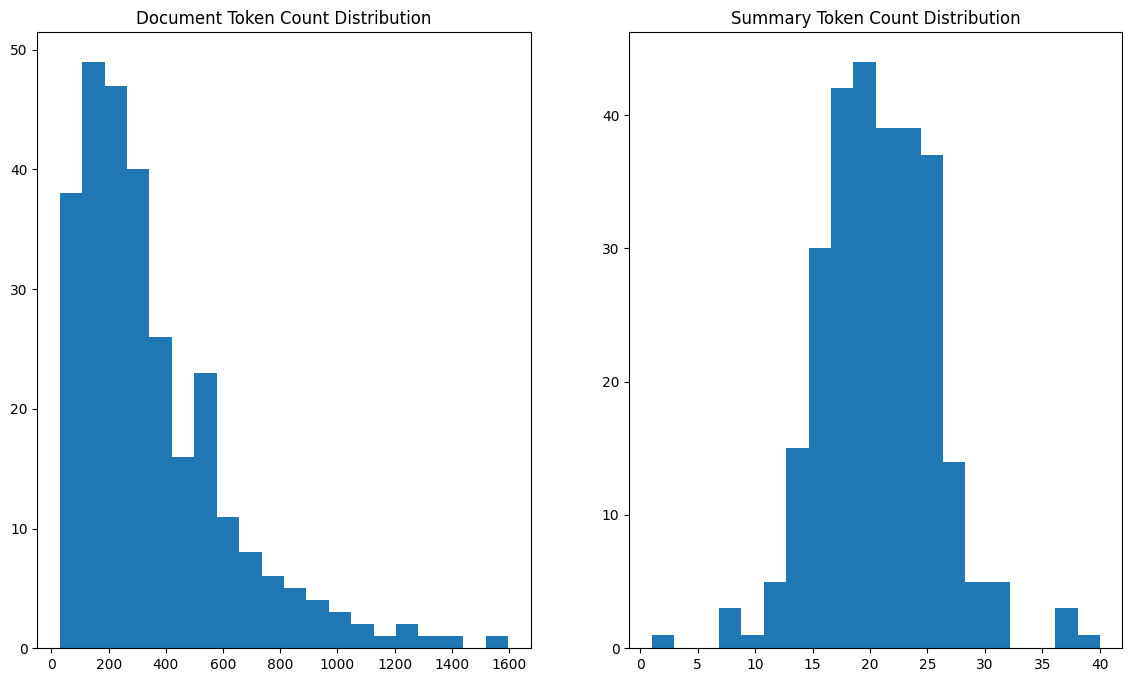

In [ ]:
import datasets
import random
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


def calculate_token_counts(dataset):
    # TO DO
    source_counts = [len(row['document'].split()) for row in dataset]
    target_counts = [len(row['summary'].split()) for row in dataset]
    return source_counts, target_counts


def token_counts_summary(raw_datasets):
     # TO DO
     for split, dataset in raw_datasets.items():
          source_counts, target_counts = calculate_token_counts(dataset)
          print(f"{split} Dataset:")
          print(f"Source Mean: {np.mean(source_counts)}, Source Std: {np.std(source_counts)}")
          print(f"Target Mean: {np.mean(target_counts)}, Target Std: {np.std(target_counts)}\n")



def show_token_counts(dataset):
    source_counts, target_counts = calculate_token_counts(dataset)
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 8))
    ax0.hist(source_counts, bins=20)
    ax1.hist(target_counts, bins=20)
    ax0.set_title("Document Token Count Distribution")
    ax1.set_title("Summary Token Count Distribution")

show_random_elements(raw_datasets["validation"])
show_token_counts(raw_datasets["validation"])
token_counts_summary(raw_datasets)

### ROUGE Metric

To evaluate our model's performance, we will use **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**. It compares *n*-grams of the model outputs to reference text but is based on recall instead of precision like BLEU. ROUGE does not impose any brevity penalty. BLEU returns a single number, ROUGE outputs multiple scores per each $n$-gram under consideration.

This metric is provided natively within the dataset library. **Note** metrics are difficult to implement correctly from scratch as decisions like lemmatisation, tokenisation and punctation-handling can create large discrepancies in scores.

You can call its `compute` method with your hypotheses and target summaries, which need to be list of decoded strings:

In [ ]:
from datasets import load_metric
metric = load_metric("rouge", trust_remote_code=True)

# help(metric)      # << Uncomment to see more about the ROUGE eval metric

predicted_summaries = ["AI applications span diverse fields.", "Enhancing efficiency, decision-making, experiences with AI."]
target_doc = 'As artificial intelligence continues to advance, researchers are exploring its applications in diverse fields such as healthcare, finance, education, and entertainment, aiming to improve efficiency, decision-making processes, and overall human experiences.'
docs = [target_doc, target_doc]

metric.compute(predictions=predicted_summaries, references=docs)

<ipython-input-6-144e8623a453>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge", trust_remote_code=True)


{'rouge1': AggregateScore(low=Score(precision=0.5714285714285714, recall=0.09375, fmeasure=0.16216216216216214), mid=Score(precision=0.5857142857142856, recall=0.109375, fmeasure=0.18364518364518362), high=Score(precision=0.6, recall=0.125, fmeasure=0.20512820512820512)),
 'rouge2': AggregateScore(low=Score(precision=0.25, recall=0.03225806451612903, fmeasure=0.05714285714285715), mid=Score(precision=0.29166666666666663, recall=0.04838709677419355, fmeasure=0.08262548262548262), high=Score(precision=0.3333333333333333, recall=0.06451612903225806, fmeasure=0.1081081081081081)),
 'rougeL': AggregateScore(low=Score(precision=0.5714285714285714, recall=0.09375, fmeasure=0.16216216216216214), mid=Score(precision=0.5857142857142856, recall=0.109375, fmeasure=0.18364518364518362), high=Score(precision=0.6, recall=0.125, fmeasure=0.20512820512820512)),
 'rougeLsum': AggregateScore(low=Score(precision=0.5714285714285714, recall=0.09375, fmeasure=0.16216216216216214), mid=Score(precision=0.58571

## Preprocessing the Data

We will proprocess the data using the Huggingface `Tokenizer` paired with T5, which tokenises input text and adds additional required tokens. This ensures that our inputs are correctly aligned with the model's embedding matrix.

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

### Using the Tokenizer

`Tokenizer` outputs are different for different tokenisers. Compare outputs below for the T5 and BERT tokenisers.


In [ ]:
print(tokenizer("AI applications span diverse fields."))

tokenizer_ = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer_('AI applications span diverse fields.')

{'input_ids': [7833, 1564, 8438, 2399, 4120, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 9932, 5097, 8487, 7578, 4249, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

As we mentioned above, T5 was trained in a multitask setup such that it can perform multiple tasks. We prefix the inputs with "summarize: " to prompt the model to summarise.

We will now create a function to preprocess our samples, feeding them to the tokeniser with the `truncation=True` argument. This ensures that any input exceeding the model's maximum accepted length will be truncated accordingly. Padding will be addressed later in a data collator, allowing us to pad examples to the longest length in the batch rather than the entire dataset.

Complete the `preprocess_function` below to prepare our training data (**Hint**: do not forget to prefix the inputs).

In [ ]:
if model_checkpoint in ["t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

In [ ]:
max_doc_len = 1024
max_sum_length = 128


def preprocess_samples(samples):

    inputs = list()

    # TO DO
    inputs = [prefix + doc for doc in samples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_doc_len, truncation=True)
    # TO DO
    targets = tokenizer(text_target = samples["summary"], max_length=max_sum_length, truncation=True)
    model_inputs["labels"] = targets["input_ids"]

    return model_inputs

This function works with one or several examples. In the case of several examples, the tokeniser will return a list of lists for each key:

In [ ]:
raw_datasets["train"][:2]

{'document': ["Leeds, playing under head coach Thomas Christiansen for the first time, went ahead through Phillips' smart finish.\nLast season's top scorer Chris Wood then headed in for 2-0, only for Bolton forward Gary Madine to nod home.\nBut Phillips' tap-in quickly restored Leeds' two-goal lead, and they held on despite Adam Le Fondre's penalty.\nThe former Reading front man smashed his spot-kick down the middle, with Conor Shaughnessy having fouled Madine almost immediately after coming on.\nBut the headlines belonged to 21-year-old Phillips, who doubled his career tally for Leeds during the first half to put the visitors in control.\nNew Zealand forward Wood, who scored 30 goals last season as Leeds narrowly missed out on the play-offs, also opened his account with a clinical header in off the underside of the bar.\nBut there will be some concern over the fitness of defenders Gaetano Berardi and Matthew Pennington, who were both forced off injured prior to half-time.\nBolton, pro

In [ ]:
preprocess_samples(raw_datasets["train"][:2])

{'input_ids': [[21603, 10, 23370, 6, 1556, 365, 819, 3763, 3576, 11337, 35, 21, 8, 166, 97, 6, 877, 2177, 190, 16202, 7, 31, 2592, 1992, 5, 2506, 774, 31, 7, 420, 2604, 52, 4409, 2985, 258, 7467, 16, 21, 3, 19423, 6, 163, 21, 1491, 7377, 1039, 13439, 5428, 630, 12, 150, 26, 234, 5, 299, 16202, 7, 31, 5011, 18, 77, 1224, 13216, 23370, 31, 192, 18, 839, 138, 991, 6, 11, 79, 1213, 30, 3, 3565, 7124, 312, 11381, 60, 31, 7, 10736, 5, 37, 1798, 9825, 851, 388, 3, 7, 23991, 112, 2140, 18, 157, 3142, 323, 8, 2214, 6, 28, 1193, 127, 3926, 14439, 655, 63, 578, 21114, 1361, 5428, 630, 966, 2017, 227, 1107, 30, 5, 299, 8, 12392, 7, 36, 23629, 12, 1401, 18, 1201, 18, 1490, 16202, 7, 6, 113, 1486, 26, 112, 1415, 3, 17, 1427, 21, 23370, 383, 8, 166, 985, 12, 474, 8, 2692, 16, 610, 5, 368, 5725, 1039, 2985, 6, 113, 5799, 604, 1766, 336, 774, 38, 23370, 5658, 120, 4785, 91, 30, 8, 577, 18, 1647, 7, 6, 92, 2946, 112, 905, 28, 3, 9, 3739, 13956, 16, 326, 8, 365, 1583, 13, 8, 1207, 5, 299, 132, 56, 36, 12

We will apply the `map` method of our `raw_datasets` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [ ]:
preprocessed_datasets = raw_datasets.map(preprocess_samples, batched=True)

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

The outcomes are automatically stored in the 🤗 Datasets library's cache, so that processing does not need to be repeated. If you need to reapply preprocessing, you can include `load_from_cache_file=False` in the map function call.

We specified `batched=True `to encode texts in batches which employs multi-threading.

## Fine-tuning T5

We will now download the pretrained model and fine-tune it. Since our task is sequence-to-sequence, we use the `AutoModelForSeq2SeqLM` class.

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Let's set the learning rate, `batch_size` and customise the weight decay.

In [ ]:
batch_size = 8
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 1

model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-xsum"

Next, we build a data collator that pads the inputs to the batch's maximum length for both inputs ans targets. Make sure to set the `return_tensors='np'` argument to obtain NumPy arrays. Our TensorFlow dataset pipeline internally employs a NumPy loader, wrapped with a tf.data.Dataset at the end. Additionally, np is required by the ROUGE metrics.


To speed up GPU computation, we specify `pad_to_multiple_of`, which snaps the padding length to the next multiple of the given value. For example, if we pad to 250 but pad_to_multiple_of=8 then we will pad to 256.

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)

We will convert our datasets into tf.data.Dataset, to be able to work with Keras. We will use Model.prepare_tf_dataset() to avoid manual specification. We re-use the collator we created earlier as our `collate_fn`.

In [ ]:
train_dataset = model.prepare_tf_dataset(
    preprocessed_datasets["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

validation_dataset = model.prepare_tf_dataset(
    preprocessed_datasets["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

Now we initialise our loss and optimizer and compile the model. Note that most Transformers models compute loss internally, so we do not need to specify any loss when we `compile()`.

In [ ]:
from transformers import AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)

Finally, we can train our model. KerasMetricCallback is a callback for computing advanced metrics. The callback takes two main arguments: `metric_fn` and `eval_dataset`. It then iterates the `eval_dataset` and collects the model's outputs for each sample. As a result, the callback passes the `list` of predictions and the associated `list` of targets to the user-defined `metric_fn`. If the `predict_with_generate` argument is `True`, then it will call `model.generate()`. This is useful for metrics like `ROUGE`.

Complete the `compute_metrics` below to decode output batches and compute ROUGE (**Hint**: you can use `tokenizer.batch_decode` and `metric.compute`).

In [ ]:
import numpy as np
import nltk


def compute_metrics(eval_predictions):

    model_predictions, true_labels = eval_predictions

    # Substitute masked true label tokens
    for label in true_labels:
        label[label < 0] = tokenizer.pad_token_id

    # TO DO
    decoded_predictions = tokenizer.batch_decode(model_predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(true_labels, skip_special_tokens=True)
    # TO DO

    # Rouge expects a newline after each sentence
    decoded_predictions = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_predictions
    ]
    decoded_targets = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels
    ]

    # TO DO
    rouge_results = metric.compute(predictions=decoded_predictions, references=decoded_targets)

    # TO DO

    # Extract relevant results
    rouge_results = {key: value.mid.fmeasure * 100 for key, value in rouge_results.items()}

    # Include mean generated length
    prediction_lengths = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in model_predictions
    ]
    rouge_results["gen_len"] = np.mean(prediction_lengths)

    return rouge_results


We will train our model now. We only do a single epoch, as inputs are very long and even one epoch can take a while.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback

metric_callback = KerasMetricCallback(
    compute_metrics, eval_dataset=validation_dataset, predict_with_generate=True
)

callbacks = [metric_callback]

model.fit(
    train_dataset, epochs=1, callbacks=callbacks)

106/106 [==============================] - ETA: 0s - loss: 3.3958 

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


106/106 [==============================] - 5162s 48s/step - loss: 3.3958 - rouge1: 17.8857 - rouge2: 3.2372 - rougeL: 14.3596 - rougeLsum: 14.3986 - gen_len: 18.7852


## Inference

Let's try now to summarise a document using our model. Do not forget to prepend "summarize: " to the input.

In [ ]:
document = 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we\'re neglected or forgotten," she said.\n"That may not be true but it is perhaps my perspective over the last few days.\n"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"\nMeanwhile, a flood alert remains in place across the Borders because of the constant rain.\nPeebles was badly hit by problems, sparking calls to introduce more defences in the area.\nScottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.\nThe Labour Party\'s deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.\nHe said it was important to get the flood protection plan right but backed calls to speed up the process.\n"I was quite taken aback by the amount of damage that has been done," he said.\n"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."\nHe said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.'
summary = 'Severe flooding in Newton Stewart and surrounding areas has caused extensive damage, ongoing repair efforts, disruptions to transportation, and calls for improved flood prevention measures, prompting visits from First Minister Nicola Sturgeon and concerns from local businesses and residents.'
# TO DO

tokenized = tokenizer("summarize: " + document, return_tensors="tf")

# TO DO
out = model.generate(**tokenized, max_length=128)

In [ ]:
out_ft = tokenizer.decode(out[0], skip_special_tokens=True)
print(out_ft)

The full cost of damage in Newton Stewart is still being assessed. many businesses and householders were affected by flooding in the town.


## Pipeline API

The pipeline API provides a convienient shortcut to many procedures. Let's use it to generate a summary with the non fine-tuned model.

In [ ]:
from transformers import pipeline

# we will use the initial T5 checkpoint we downloaded before fine-tuning
summarizer = pipeline('text2text-generation', model_checkpoint, framework="tf")

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


**Task 2: Compare performance of the fine-tuned model to generic output**

Summarise the document provided above using the generic model (no fine-tuning). Compute ROUGE scores and comment on the efficiency of fine-tuning.

In [ ]:
out = summarizer(document, max_length=128)
out_zero_shot = out[0]['generated_text']
print(out_zero_shot)

the flood protection plan was right but backed calls to speed up the process . the full cost of damage in Newton Stewart is still being assessed . many roads in Peeblesshire remain badly affected by standing water .


In [ ]:
metric.compute(predictions=[out_ft], references=[summary])

{'rouge1': AggregateScore(low=Score(precision=0.30434782608695654, recall=0.1794871794871795, fmeasure=0.22580645161290322), mid=Score(precision=0.30434782608695654, recall=0.1794871794871795, fmeasure=0.22580645161290322), high=Score(precision=0.30434782608695654, recall=0.1794871794871795, fmeasure=0.22580645161290322)),
 'rouge2': AggregateScore(low=Score(precision=0.18181818181818182, recall=0.10526315789473684, fmeasure=0.13333333333333333), mid=Score(precision=0.18181818181818182, recall=0.10526315789473684, fmeasure=0.13333333333333333), high=Score(precision=0.18181818181818182, recall=0.10526315789473684, fmeasure=0.13333333333333333)),
 'rougeL': AggregateScore(low=Score(precision=0.21739130434782608, recall=0.1282051282051282, fmeasure=0.16129032258064516), mid=Score(precision=0.21739130434782608, recall=0.1282051282051282, fmeasure=0.16129032258064516), high=Score(precision=0.21739130434782608, recall=0.1282051282051282, fmeasure=0.16129032258064516)),
 'rougeLsum': Aggregat

In [ ]:
metric.compute(predictions=[out_zero_shot], references=[summary])

{'rouge1': AggregateScore(low=Score(precision=0.19444444444444445, recall=0.1794871794871795, fmeasure=0.18666666666666665), mid=Score(precision=0.19444444444444445, recall=0.1794871794871795, fmeasure=0.18666666666666665), high=Score(precision=0.19444444444444445, recall=0.1794871794871795, fmeasure=0.18666666666666665)),
 'rouge2': AggregateScore(low=Score(precision=0.05714285714285714, recall=0.05263157894736842, fmeasure=0.05479452054794521), mid=Score(precision=0.05714285714285714, recall=0.05263157894736842, fmeasure=0.05479452054794521), high=Score(precision=0.05714285714285714, recall=0.05263157894736842, fmeasure=0.05479452054794521)),
 'rougeL': AggregateScore(low=Score(precision=0.08333333333333333, recall=0.07692307692307693, fmeasure=0.08), mid=Score(precision=0.08333333333333333, recall=0.07692307692307693, fmeasure=0.08), high=Score(precision=0.08333333333333333, recall=0.07692307692307693, fmeasure=0.08)),
 'rougeLsum': AggregateScore(low=Score(precision=0.0833333333333

## Textual data generation using keywords


One possible way to generate new text for data augmentation is to guide the generation of new text using keywords extracted from original data. In this task, you will fine-tune T5 to generate new text based on keywords extracted from the original summaries of the XSum dataset you have seen in the first part of this lab.  Fine-tuning T5 on such a task would leverage the model capabilities to produce new text that captures the core meaning of the original based on the provided keywords.

**Task 3: Build and evaluate a T5-based model for data generation using keywords.**

Complete the `preprocess_samples_data_gen` below to extract 10 random words from each summary. Those ten random words will be further tokenised and used as inputs to T5. Note that in this task you do not need to prepend "summarize: ".

In [ ]:
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def preprocess_samples_data_gen(samples):

    inputs = list()

    for doc in samples["summary"]:
      # TO DO
        words = word_tokenize(doc)
        # Ensure we have a unique set of words for randomness
        unique_words = list(set(words))
        # If the document has less than 10 unique words, use as many as available
        num_words_to_select = min(10, len(unique_words))
        # Randomly select 10 words, or fewer if the document is short
        selected_words = random.sample(unique_words, num_words_to_select)
        # Join the selected words into a string and add to inputs
        inputs.append(' '.join(selected_words))

    model_inputs = tokenizer(inputs, max_length=max_doc_len, truncation=True)
    targets = tokenizer(text_target = samples["summary"], max_length=max_sum_length, truncation=True)

    model_inputs["labels"] = targets["input_ids"]

    return model_inputs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now we can preprocess, collate and prepare our new dataset in the similar way we have done before.

In [ ]:
preprocessed_datasets_data_gen = raw_datasets.map(preprocess_samples_data_gen, batched=True)

Map:   0%|          | 0/849 [00:00<?, ? examples/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model_data_gen = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_data_gen, return_tensors="np")

generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_data_gen, return_tensors="np", pad_to_multiple_of=128)

In [ ]:
train_dataset = model.prepare_tf_dataset(
    preprocessed_datasets_data_gen["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

validation_dataset = model.prepare_tf_dataset(
    preprocessed_datasets_data_gen["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

generation_dataset = model.prepare_tf_dataset(
    preprocessed_datasets_data_gen["validation"],
    batch_size=8,
    shuffle=False,
    collate_fn=generation_data_collator
)

Now we initialise our loss and optimizer and compile the model. Note that most Transformers models compute loss internally, so we do not need to specify any loss when we `compile()`.

In [ ]:
from transformers import AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model_data_gen.compile(optimizer=optimizer)

We will finally fine-tune our model for five epochs.

In [ ]:
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
model_data_gen.fit(
    train_dataset, epochs=5)

Epoch 1/5
106/106 [==============================] - 391s 3s/step - loss: 3.9563
Epoch 2/5
106/106 [==============================] - 349s 3s/step - loss: 3.5842
Epoch 3/5
106/106 [==============================] - 360s 3s/step - loss: 3.4281
Epoch 4/5
106/106 [==============================] - 375s 4s/step - loss: 3.3359
Epoch 5/5
106/106 [==============================] - 377s 4s/step - loss: 3.2446


Let's try now to generate a document using pre-set keywords. We again do not need to prepend the 'summarize:' prompt.

In [ ]:
document = 'damage ongoing Hawick disruption Lamington viaduct commercial thoroughfare multi-agency neglected'

tokenized = tokenizer([document], return_tensors='np')
out = model_data_gen.generate(**tokenized, max_length=128)

In [ ]:
out_ft = tokenizer.decode(out[0], skip_special_tokens=True)
print(out_ft)

Hawick has been unable to restore its commercial premises in the area of Hawick, which is a multi-agency neglected and neglected business.
